In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures #library for threading

## Group Assignment
### Team Number: 13
### Team Member Names: Saad Ali, Vivian Guo, Alex Zhang
### Team Strategy Chosen: SAFE Portfolio

### Begin by gathering and filtering stock data to requirements:

In [2]:
#importing csv file with tickers
sample = pd.read_csv('Tickers.csv', names = ['Tickers'])
sample.head()

,Tickers
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AGN


In [3]:
#gets a string of space separated stock tickers
just_tickers = sample["Tickers"].to_numpy()
just_tickers = just_tickers.tolist()
str_tickers = ' '.join(just_tickers)

#downloading closing price data (time interval of 3 years for use in later analysis)
start_date = '2018-11-01' 
end_date = '2021-10-22'
    
data = yf.download(str_tickers, start=start_date, end=end_date)
invalid_data = list(yf.shared._ERRORS.keys())
print(list(yf.shared._ERRORS.keys()))

[*********************100%***********************]  62 of 62 completed

5 Failed downloads:
- PCLN: No data found for this date range, symbol may be delisted
- AGN: No data found, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
- CELG: No data found, symbol may be delisted
['PCLN', 'AGN', 'RTN', 'TWX', 'CELG']


In [4]:
#prelimanary filter - removes all tickers without yfinance data
for i in range (len(invalid_data)):
    just_tickers.remove(invalid_data[i]) 
    
#filters out stocks with average trading volume less than 10000
for i in range (len(just_tickers)):
    current_ticker = just_tickers[i]
    if (data["Volume"][current_ticker].mean() < 10000):
        just_tickers.remove(just_tickers[i])

In [5]:
#takes ~35 seconds to run
#df = pd.DataFrame()
data_list = []
#function to get data from yfinance.info
def download_data(ticker):
    hist = yf.Ticker(ticker).history(start=start_date, end=end_date)
    #if statement to check data availability of a stock - if there is not enough data available
    # the stock is dropped as predictions on that stock will be less reliable
    if hist.index[0] != pd.to_datetime(start_date):   
        pass
    else:
        #adding stock data for valid stocks
        info = yf.Ticker(ticker).info
        row = [ticker, info["currency"], info["beta"], info["sector"]] 
        data_list.append(row)
#threading to reduce runtime
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(download_data, just_tickers)

#turning stock info into a dataframe
stock_info = pd.DataFrame(data_list)
stock_info = stock_info.rename(columns={0: 'Ticker', 1:'Currency', 2: 'Beta', 3:'sector'})
stock_info.head()

,Ticker,Currency,Beta,sector
0,AXP,USD,1.224415,Financial Services
1,ACN,USD,1.128831,Technology
2,BLK,USD,1.203116,Financial Services
3,ABT,USD,0.668051,Healthcare
4,AAPL,USD,1.205714,Technology


In [6]:
#Get the total number of unique industies in the given tickers (for use in portfolio diversification later)
all_unique = len(stock_info.sector.value_counts())
print("Number of Unique Industries: " + str(all_unique))

Number of Unique Industries: 10


In [7]:
#find non usd currency and dropping the associated stock
for i in range(len(stock_info.index)):
    if (stock_info["Currency"][i] != "USD"):
        stock_info = stock_info.drop([i])   

### Forming an initial portfolio of ten stocks with the lowest Betas


Beta measures the volatility, or risk of a stock or portfolio’s return relative to the market’s return. Beta values more than one indicates an investment has risk above the market, values less than one but greater than zero mean lower risk than the market, while values less than zero indicate an inverse relation to the market.

Starting with a portfolio of ten stocks with the lowest beta ensures that the portfolio begins safe relative to the market. This forms a foundational portfolio to later further diversify upon with factors such as industry and correlation. By choosing the lowest possible betas as the starting portfolio, even if those stocks are correlated, the risk would be relatively minimal compared to choosing stocks with low correlation, but high beta instead.

(The S&P 500 (^GSPC is the market index used for comparison for this portfolio.)

---

In [8]:
#function for manually calculating beta
#Yahoo finance uses S&P500 as the index for comparison and monthly return data over a 3Y period
def calculate_beta (ticker, market_ticker):
    stock = yf.Ticker(ticker)
    market_index = yf.Ticker(market_ticker)

    end_date = str(datetime.now())[0:10]      #get end date as current date in the form of yyyy-mm-dd
    start_year = str(int(end_date[0:4])-3)    #finding start year by subtracting 3 from the current year
    start_date = start_year + end_date[4:10]  #combine to get a start date 3 years back from present

    #getting whatever stock data is available
    stock_data = stock.history(start = start_date, end = end_date)
    index_data = market_index.history(start = stock_data.index[0], end = end_date)
    
    #calculating returns for stock and market index and storing into a dataframe
    stock_return = pd.DataFrame(stock_data["Close"])
    stock_return = stock_return.rename(columns= {'Close': 'Stock'})
    stock_return["Market"] = index_data["Close"]
    stock_return = stock_return.resample('MS').first().pct_change() * 100
    stock_return = stock_return.drop([stock_return.index[0]])               #drops first nan value
    
    #calculating market variance
    market_var=stock_return["Market"].var()
    #calculating beta 
    beta=stock_return.cov()/ market_var
    return beta

#find beta with no value and insert calculated beta
stock_info = stock_info.reset_index(drop=True)

for i in range(len(stock_info.index)):
    if (np.isnan(stock_info["Beta"][i])):
        stock_info = stock_info.drop([stock_info.index[i]])

In [9]:
#sorting stocks by beta values (lowest beta to highest)
stock_info = stock_info.sort_values("Beta")

In [10]:
#Find the different sectors of the stocks
sector_list = (stock_info["sector"].unique()).tolist()

#list of tickers filtered by sector then beta (low to high) within each sector
df_list = []
for i in sector_list:
    temp = stock_info[stock_info.sector.isin([i])]
    df_list.append(temp.sort_values("Beta"))
    
#df_list is a list of a dataframe

In [11]:
#Initialization of portfolio dataframe
portfolio = pd.DataFrame(columns=['Ticker', 'Currency', 'Beta', 'Sector'])

In [12]:
#keep track of tickers not in the initial portfolio to add in later
not_added_ticks = stock_info[10:]

#forming a portfolio of the stocks with the lowest beta 
def lowestBetaTickers(df):
    return df.sort_values("Beta").head(10)

lowest = pd.DataFrame(lowestBetaTickers (stock_info))
lowest = lowest.rename(columns ={0: "Ticker", 1: "Beta"})
lowest.reset_index(inplace=True)
lowest.drop(['index'], axis=1, inplace=True)
#output of low-beta portfolio
lowest.head()

,Ticker,Currency,Beta,sector
0,NEE,USD,0.263376,Utilities
1,LLY,USD,0.315844,Healthcare
2,BIIB,USD,0.401558,Healthcare
3,PG,USD,0.411948,Consumer Defensive
4,SO,USD,0.459220,Utilities


**Comparison of high beta ticker and low beta ticker prices**

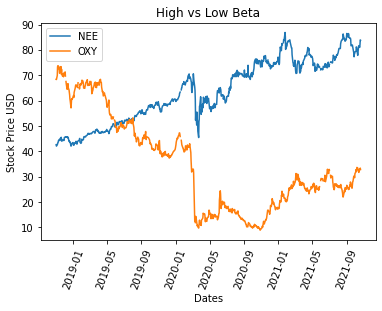

In [13]:
#comparison of stocks with a low beta vs a high beta
#gets tickers of lowest and highest beta 
min_beta = lowest["Ticker"][0]
max_beta = not_added_ticks.loc[not_added_ticks["Beta"].idxmax()]["Ticker"]

#putting closing price data into dataframes
min_beta_close = pd.DataFrame(data["Close"][min_beta])
max_beta_close = pd.DataFrame(data["Close"][max_beta])

#graphing closing price changes 
plt.plot(min_beta_close.index, min_beta_close, label=min_beta)
plt.plot(max_beta_close.index, max_beta_close, label=max_beta)
#graph labels
plt.title('High vs Low Beta')
plt.xlabel('Dates')
plt.xticks(rotation=70)
plt.ylabel('Stock Price USD') 
#create legend
plt.legend(loc='best')
#display graph
plt.show()

By observing the graph of closing price data of the low-beta stock and high-beta stock, one can see the high-beta stock is subject to more fluctuations; higher beta stocks are more volatile than lower beta stocks. This supports the reasoning for starting off a portfolio with low-beta stocks as these stocks will have the lowest movements and risk out of all available stocks in the csv.

In [14]:
#storing unique industries and frequency into a dataframe (for use in diversifying across industries)
inbeta_unique = pd.DataFrame(lowest.sector.value_counts())
inbeta_unique = inbeta_unique.rename(columns={"sector": "frequency"})
inbeta_unique.head()

,frequency
Healthcare,4
Consumer Defensive,4
Utilities,2


### Finding lowest correlated stocks with the low-beta portfolio

Since the purpose of this portfolio is to be as safe as possible, it would be ideal to diversify the portfolio to dilute the effects of non-systematic risks. However, since the 10 low beta stocks have an unknown correlation, it would be helpful to create a “derivative” that helps counteract the fluctuations of the beta portfolio. Therefore, calculating the overall return of the beta portfolio, and then finding the correlation between the beta portfolio and each of the remaining stocks can help us identify which stocks can best complement the beta portfolio. 

To do this, we looked at two factors: low correlation and industry. We chose to limit the correlation to 0.4 because if the rest of the stocks have a high correlation with the low beta portfolio, then adding those stocks will only increase the risk.

To make the industries unbiased, a counter was created to ensure that no one industry can dominate the entire portfolio. If an industry was taking up most of the portfolio, some of its tickers are removed to rebalance the portfolio.

Ultimately, by adding additional stocks that have a low correlation with the low beta portfolio from different industries, we can effectively reduce the non-systematic risk and increase diversification.

---

In [15]:
#Find n (0, 10) stocks that are negatively corrolated to the 10 lowest beta portfolio, 
#and then turn those 10 stocks into a portfolio
end_date = str(datetime.now())[0:10]      #get end date as current date in the form of yyyy-mm-dd
start_year = str(int(end_date[0:4])-3)    #finding start year by subtracting 3 from the current year
start_date = start_year + end_date[4:10]  #combine to get a start date 3 years back from present

#making an evenly weighted portfolio for the purpose of getting returns for analysis
p1_tickers = lowest["Ticker"]

#function to store closing prices of a list of stocks (tickers is a list of tickers, sd is start date, ed is end date)
def store_close(tickers, sd, ed):
    for i in range(len(tickers)):
        #getting data for one stock ticker
        current_ticker = tickers[i]
        ticker_info = yf.Ticker(current_ticker)
        ticker_hist = ticker_info.history(start = sd, end=ed)
        #creates a dataframe if its the first ticker
        if (i == 0):
            stored_close = pd.DataFrame(ticker_hist.Close)
            stored_close.rename({"Close": ((current_ticker + " Close"))}, axis=1, inplace=True)
        else: #otherwise add data to existing dataframe
            stored_close.loc[:, ((current_ticker + " Close"))] = ticker_hist.Close
    #to get monthly data
    stored_close = stored_close.resample('MS').first()   
    return stored_close

#function call
p1_close = store_close(p1_tickers, start_date, end_date)
p1_close.head()

,NEE Close,LLY Close,BIIB Close,PG Close,SO Close,MRK Close,CL Close,BMY Close,PEP Close,COST Close
Date,,,,,,,,,,
2018-11-01,41.501026,109.104820,332.239990,86.119820,40.564335,67.233833,58.514046,47.269203,109.268532,219.090271
2018-12-01,42.802769,111.928535,332.190002,86.406876,41.769314,68.966278,59.380157,48.432751,109.711136,220.745316
2019-01-01,39.833385,108.490967,304.690002,84.517990,38.453449,66.267410,55.179966,47.660080,101.566902,194.759613
2019-02-01,41.707424,114.166725,330.910004,90.963242,42.648857,67.021347,60.990559,45.708599,104.271538,200.000488
2019-03-01,44.286030,122.334061,334.100006,91.868484,44.502064,71.580017,61.881256,48.759502,108.855507,209.286407


In [16]:
#function to make portfolios for analysis 
#(tickers: list of stock tickers, prices: closing prices, initial: investment amount)
def make_temp_portfolio (tickers, prices, initial):
    
    #calculates how much initial capital goes to each stock with an even weighting
    initial_split = initial / len(tickers.index)
    #list to store number of stocks to purchase for each company
    num_of_stocks = []
    
    #for loop to find how many stocks can be purchased for each company
    for a in range(len(tickers.index)):
        stock_col = tickers[a] + " Close"
        stock_price = prices[stock_col][0]
        num_of_stocks.append(initial_split / stock_price)
    
    #for loop to calculate portfolio value over time
    portfolio = prices.copy()
    portfolio["Portfolio"] = 0

    #gets portflio value
    for b in range (len(prices.index)):
        #resets for next addition #CONSIDER PUTTING EACH INDIVIDUAL STOCK PORT VALUE INTO COLUMNS
        value = 0
        #sums each row 
        for c in range (len(tickers.index)):
            stock_col = tickers[c] + " Close"
            value = value + (prices[stock_col][b] *  num_of_stocks[c])
        #sets value for each row
        pd.options.mode.chained_assignment = None
        portfolio["Portfolio"][b] = value
        
        
    portfolio["Return"] = portfolio["Portfolio"].pct_change()*100
    return portfolio
#getting return of low-beta portfolio
p1_return = make_temp_portfolio (p1_tickers, p1_close, 100000)["Return"]
#storing low-beta portfolio return for calculating correlation later
compare_return = pd.DataFrame(p1_return)

In [17]:
#makes dataframe of remaining stocks not yet put into the portfolio
not_added = pd.DataFrame(not_added_ticks)
not_added = not_added.reset_index()
#not_added = not_added.rename(columns={"index": "Ticker", 0: "Beta"})
not_added.drop(['index'], axis=1, inplace=True)
not_added.head()

,Ticker,Currency,Beta,sector
0,T,USD,0.659740,Communication Services
1,KO,USD,0.662337,Consumer Defensive
2,PFE,USD,0.665974,Healthcare
3,ABT,USD,0.668051,Healthcare
4,MO,USD,0.673766,Consumer Defensive


In [18]:
#find negative/low correlated stocks with the portfolio - consumes a list of stocks 
#~20sec ish to run

#takes in dataframe of returns of initial 10 portfolio, and a dataframe of remaining stocks and their betas
def find_corr (initial, to_add):
    corrs = []
    
    for i in range (len(to_add.index)):
    #calculate return of just one stock
        ticker = to_add["Ticker"][i]
        stock_close = yf.Ticker(ticker).history(start = start_date, end=end_date)["Close"]
        stock_return = pd.DataFrame(stock_close)
        stock_return = stock_return.resample('MS').first().pct_change() * 100
        
        #putting the low-beta portfolio's return and the stock we are checking's return in one portfolio
        to_compare = pd.concat([initial, stock_return], axis=1)
        to_compare.drop(index=to_compare.index[0],inplace=True)
        #calculating correlation and storing to the list of correlations
        temp = pd.DataFrame(to_compare.corr())
        corrs.append (temp["Return"]["Close"])
        
    return corrs

#adding correlations to a dataframe with their associated stocks
not_added["corr"] = find_corr (compare_return, not_added)
not_added.head()

,Ticker,Currency,Beta,sector,corr
0,T,USD,0.659740,Communication Services,0.674203
1,KO,USD,0.662337,Consumer Defensive,0.716255
2,PFE,USD,0.665974,Healthcare,0.615354
3,ABT,USD,0.668051,Healthcare,0.667633
4,MO,USD,0.673766,Consumer Defensive,0.296788


Since it is arbitrary how many industries the stock data will be spread across, the program aims to find a balance between diversifying across industries while not being forced to select high correlation stocks for the sake of industry diversification. Under reasonable market conditions, 60% should allow for industry diversification while not limiting choices for low correlation stocks. 

In [19]:
#ensuring diversification across industries (aiming for >60% total unique industries)
#calculates the number of unique industries to add based on what sectors are covered in the beta portfolio
target_count = int(0.6*(all_unique))
toadd_unique = target_count - len(inbeta_unique.index)

#calculating the maximum number of stocks in one industry in the portfolio based on 
#the calculated target industry spread in the portfolio
max_per_i = int(20/(target_count-1)) #-1 to ensure that room is allowed for 20 stocks incase of rounding down


In [20]:
#find 10 lowest correlation stocks with the portfolio
lowest_corr = not_added.sort_values("corr")[0:10]

#check to ensure that all lowest correlation stocks are below a certain value and meet industry requirments
for i in range(len(lowest_corr["corr"])):
    if (lowest_corr.iloc[i]["corr"] > 0.4):
        filtered_corr = lowest_corr[0:(i-1)]
        break
        
#fixing indices
lowest_corr = lowest_corr.reset_index(drop=True)
filtered_corr = filtered_corr.reset_index(drop=True)
filtered_corr.head()

,Ticker,Currency,Beta,sector,corr
0,CAT,USD,0.909610,Industrials,0.217123
1,MO,USD,0.673766,Consumer Defensive,0.296788
2,COP,USD,1.625454,Energy,0.342949
3,OXY,USD,2.356883,Energy,0.353992
4,UPS,USD,1.113246,Industrials,0.358710


#### FOR ANALYSIS + GRAPHING PURPOSES: forming a high correlated portfolio to show effect of low correlation on diversification

In [21]:
#high correlation portfolio for analysis

#find 10 highest correlation stocks with the portfolio and stores into the dataframe highest_corr
endv = len(not_added.sort_values("corr"))
highest_corr = not_added.sort_values("corr")[(endv-10):endv]
highest_corr = highest_corr.sort_values(by='corr', ascending=False)
highest_corr = highest_corr.reset_index(drop=True)
highest_corr

#forming a high correlated portfolio
high_tickers =  lowest["Ticker"].tolist() + highest_corr["Ticker"].tolist()
high_tickers = pd.Series(high_tickers)

high_close = store_close(high_tickers, start_date, end_date)
high_portfolio = make_temp_portfolio (high_tickers, high_close, 100000)

high_std = high_portfolio["Return"].std()
print("high correlation portfolio's standard deviation: " + str(high_std))

#forming a temporary low correlated portfolio for analysis purposes
low_tickers =  lowest["Ticker"].tolist() + lowest_corr["Ticker"].tolist()
low_tickers = pd.Series(low_tickers)

low_close = store_close(low_tickers, start_date, end_date)
low_portfolio = make_temp_portfolio (low_tickers, low_close, 100000)

low_std = low_portfolio["Return"].std()
print("low correlation portfolio (before industry diversification)'s standard deviation: " + str(low_std))


high correlation portfolio's standard deviation: 4.7535927069581865
low correlation portfolio (before industry diversification)'s standard deviation: 4.302253269625688


One should observe that the standard deviation of the beta and low-correlation stock portfolio is lower than its counterpart, as adding stocks of lower correlation to a portfolio would decrease volatility and therefore risk, while adding higher correlated stocks will have the opposite effect.

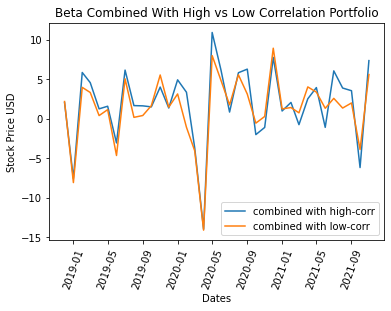

In [22]:
#comparison of stocks with low correlation vs high correlation stocks added to initial beta portfolio
#graphing closing price changes 
plt.plot(high_portfolio.index, high_portfolio["Return"], label= "combined with high-corr")
plt.plot(low_portfolio.index, low_portfolio["Return"], label= "combined with low-corr")
#graph labels
plt.title('Beta Combined With High vs Low Correlation Portfolio')
plt.xlabel('Dates')
plt.xticks(rotation=70)
plt.ylabel('Stock Price USD') 
#create legend
plt.legend(loc='best')
#display graph
plt.show()

One can observe that the portfolio of beta and low correlated stocks varies across a smaller range than the other, indicating less volatility from diversification.

**Accounting for balance in industries for the overall portfolio**

In [23]:
#finding unique industries in the low-corr portfolio
filtered_unique = pd.DataFrame(filtered_corr.sector.value_counts())
filtered_unique = filtered_unique.rename(columns={"sector": "frequency"})
filtered_unique.head()

,frequency
Industrials,2
Energy,2
Consumer Defensive,1
Healthcare,1
Technology,1


In [24]:
#combining two dataframes of unique industries 
#converting unique industries and frequencies in the beta portfolio to lists
unique_industries = inbeta_unique.index.tolist()
unique_counts = inbeta_unique["frequency"].tolist()

#set looping index
original_length = len(unique_industries)

#turn idustries in filtered stocks to a list
indus_infiltered = filtered_unique.index.tolist()
freq_infiltered = filtered_unique["frequency"].tolist()

#merging the two datasets
for i in range(len(indus_infiltered)):

    added = False
    #checks to see if an industry in the corr portfolio matches an existing
    for h in range (original_length):       
        if (indus_infiltered[i] == unique_industries[h]):
            unique_counts[h] = unique_counts[h] + freq_infiltered[i] 
            added = True
            break
        
    if (added==False):
        unique_industries = unique_industries + [indus_infiltered[i]]
        unique_counts = unique_counts + [freq_infiltered[i]]
        
#forming a dataframe of overall frequencies of industries
combined_unique = pd.DataFrame(unique_counts, index=unique_industries)
combined_unique = combined_unique.rename(columns={0: "frequency"})
combined_unique.head()

,frequency
Healthcare,5
Consumer Defensive,5
Utilities,2
Industrials,2
Energy,2


In [25]:
#removes excess stocks in one industry
#filter for frequencies above threshhold 
remove_excess = combined_unique[combined_unique.frequency > max_per_i]

#storing how many stocks should be removed for the corresponding industries
remove_excess["frequency"] = remove_excess["frequency"] - max_per_i

#locating and removing the excess stocks in the low-correlation portfolio
#for loop starts at the end to remove the higher correlated stocks first 
for i in range(1, (len(filtered_corr["corr"]))):
    ri = (len(filtered_corr["corr"])) - i
    if (ri < 0):
        break
    for h in range (len(remove_excess["frequency"])):
        if ((filtered_corr.iloc[ri].sector == remove_excess.iloc[h].name) and (remove_excess["frequency"][h] > 0)):
            filtered_corr = filtered_corr.drop([ri])
            remove_excess["frequency"][h] = remove_excess["frequency"][h]-1

#filtered low-corr portfolio with industry spread considered
filtered_corr.reset_index(inplace=True)
filtered_corr.head()

,index,Ticker,Currency,Beta,sector,corr
0,0,CAT,USD,0.909610,Industrials,0.217123
1,2,COP,USD,1.625454,Energy,0.342949
2,3,OXY,USD,2.356883,Energy,0.353992
3,4,UPS,USD,1.113246,Industrials,0.358710
4,6,ORCL,USD,0.800000,Technology,0.370457


In [26]:
#getting closing price data of low-corr stocks
p2_close = store_close(filtered_corr['Ticker'].to_list(), start_date, end_date)

### Optimizing the portfolio with the Sharpe ratio

The portfolio begins as the ten stocks with the lowest Beta then is combined with a portfolio of stocks of lowest correlation to the starting ten. 

The beginning portfolio of stocks with the lowest Beta values creates a portfolio that fluctuates less than the market. Stocks with the lowest correlation to the initial ten reflect that these stocks may be across different industries, or are historically influenced by different events. As such, these stocks with negative or low correlation to the initial ten help diversify for non-systematic industry risk in the portfolio. As well, having more stocks significantly reduces the risk associated with individual companies. The code limits stocks added to a correlation of less than 0.4 to achieve a balance in non-systematic risk diversification. 

The resulting total number stocks in the portfolio will fall between 10 to 20; the portfolio will span across industries and have low-correlated stocks to achieve diversification. 

The Sharpe ratio is a measurement of the return per unit of risk that an investor takes on. The highest Sharpe ratio tells the investor which portfolio may generate the most returns for the risk he or she is exposed to. This measurement is suitable for our portfolio’s investment goal: to maximize return after minimizing risk. 

Our portfolio consists of two components; a portfolio of the ten stocks with the lowest Beta and ten with the lowest correlation to the portfolio of stocks found by low Beta. The ratio is calculated for all possible portfolios based on stock weighting restrictions. Each measured portfolio has a different weighting in the Beta measured portion versus the correlation measured portion. The optimal weighting that generates the most return for the risk taken corresponds to the highest sharpe ratio; the optimal weighting is used to calculate the final portfolio. 

---

In [27]:
#checking to see if sharpe ratio is affected by different lengths 
def optimalSharpe(num_corrstocks):
    #forming series to store the ratio
    ratios = pd.Series(dtype='float64')
    stds = pd.Series(dtype = 'float64')
    # calculating the minimum value of each stock
    minCalc = (100 / (2*((num_corrstocks) + (len(lowest["Ticker"])))))
    if isinstance(minCalc, int):
        minValue = minCalc * num_corrstocks 
    else:
        minValue = ((int(minCalc)) + 1) * num_corrstocks
    new_index = []     
    
    #for loop to calculate ratios and standard deviations for each weighting
    if num_corrstocks == 0:
        return [1, 0]
    for i in range (minValue, (min(100-minValue, num_corrstocks*35))):
        new_index.append(i)
        #weighted starting investment for each portfolio component
        corr_w = i/100 
        beta_w = (100-i) /100

        #making the low-beta component of the portfolio
        beta_portfolio = make_temp_portfolio(lowest["Ticker"], p1_close, (beta_w*100000))
        beta_portfolio = pd.DataFrame(beta_portfolio["Portfolio"])
        beta_portfolio = beta_portfolio.rename(columns={"Portfolio" : "Lowest Beta Portfolio"})

        #making the low-corr component 
        combined_portfolio = make_temp_portfolio(filtered_corr["Ticker"], p2_close, (corr_w*100000))
        combined_portfolio = pd.DataFrame(combined_portfolio)

        #combining
        combined_portfolio = pd.concat([combined_portfolio, beta_portfolio], axis=1)
        combined_portfolio["Combined Portfolio"]= (combined_portfolio["Portfolio"]
                                             + combined_portfolio["Lowest Beta Portfolio"])


        combined_portfolio["Combined Returns"] = combined_portfolio["Combined Portfolio"].pct_change()
        #Standard deviation for each weighting
        this_std = combined_portfolio["Combined Returns"].std()
        stds = stds.append(pd.Series(this_std))
        #sharpe ratio for each weighting
        r = combined_portfolio["Combined Returns"].mean() / this_std
        ratios = ratios.append(pd.Series(r))

    #putting sharpe ratio and standard deviation into a dataframe
    analysis = pd.DataFrame(ratios)
    analysis = analysis.rename(columns = {0 : "Sharpe Ratio"})
    analysis.set_index([new_index], inplace=True)

    #finds the max value of the sharpe ratio and locates it in the dataframe
    max_ratio = analysis["Sharpe Ratio"].max()
    index = analysis[analysis["Sharpe Ratio"]==max_ratio].index.values[0]
    corr_w = index/100
    beta_w = (100-index) /100
    
    #output
    result = [beta_w, corr_w]
    return result

sharpe = optimalSharpe(len(filtered_corr))

print("Optimal Weightings:")
print("Beta: " + str(sharpe[0]) + " (invest $" + str(sharpe[0]*100000) + ")")
print("Low Corrolation: " + str(sharpe[1]) + " (invest $" + str(sharpe[1]*100000) + ")")

Optimal Weightings:
Beta: 0.8 (invest $80000.0)
Low Corrolation: 0.2 (invest $20000.0)


**For Analysis: calculating standard deviation of the final portfolio**

In [28]:
#get list of final tickers 
final_tickers1 = filtered_corr.Ticker.to_list()+stock_info.Ticker[0:10].to_list()
final_tickers1 = pd.Series(final_tickers1)
#getting closing data of final tickers
final1_close = store_close(final_tickers1, start_date, end_date)
final1_portfolio = make_temp_portfolio (final_tickers1, final1_close, 100000)
#forming a portfolio for standard deviation calculations 
final1_std = final1_portfolio["Return"].std()
print("final portfolio's standard deviation: " + str(final1_std))

final portfolio's standard deviation: 4.014436118339196


Comparing the standard deviation of the final portfolio versus the standard deviation of the portfolio before the industry was accounted for, one should see that the final portfolio's deviation is lower than the previous since inter-industry diversification decreases non-systematic risk. In the chance that the low correlated portfolio did not surpass the maximum number of stocks allowed in one industry, the deviation will already be minimized. 


---

### Forming the final portfolio and exporting to CSV

In [29]:
#Setting a variable as the date
date = '2021-11-26'
#setting the investment amount for forming the final portfolio
Price = 100000
#getting final tickers
final_tickers = filtered_corr.Ticker.to_list()+stock_info.Ticker[0:10].to_list()
#initialization of portfolio dataframe
FinalPortfolio = pd.DataFrame(columns=['Ticker', 'Price', 'Shares', 'Value', 'Weight'])
FinalPortfolio['Ticker'] = final_tickers

#for loop to form the portfolio
for i in FinalPortfolio.index:
    ticker = yf.Ticker(FinalPortfolio.Ticker[i])
    FinalPortfolio.Price[i] = ticker.history(start = date, end = '2021-11-27')['Close'][0]
    #calculating weight and value based on optimized data from sharpe ratio
    if i <= len(filtered_corr)-1:
        FinalPortfolio.Weight[i] = sharpe[1]/len(filtered_corr)
    else:
        FinalPortfolio.Weight[i] = sharpe[0]/10
    ####NEW CODE#####
    #(it is just a one line fix)#
    #The issue was that while sending different versions of code over a social media platform,the platform messed up
    #formating of code blocks and moved the part where weight was multiplied with price to the next line, which lead 
    #to the portfolio exceeding the maximum amount.
    FinalPortfolio.Shares[i] =  Price*FinalPortfolio.Weight[i]/FinalPortfolio.Price[i]
    FinalPortfolio.Value[i] =  FinalPortfolio.Price[i]*FinalPortfolio.Shares[i]

#index clean up and final output
FinalPortfolio.index = FinalPortfolio.index + 1
FinalPortfolio.head()

,Ticker,Price,Shares,Value,Weight
1,CAT,201.419998,19.859001,4000.0,0.04
2,COP,72.720001,55.0055,4000.0,0.04
3,OXY,30.639999,130.548305,4000.0,0.04
4,UPS,206.449997,19.375152,4000.0,0.04
5,ORCL,94.660004,42.256495,4000.0,0.04


In [30]:
#final csv file output
Stocks = FinalPortfolio[['Ticker','Shares']]
Stocks.index = range(1, Stocks.shape[0] + 1)
#dataframe to csv
Stocks.to_csv('Stocks_Group_13.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Saad Ali, Vivian Guo, Alex Zhang